In [82]:
from itertools import cycle
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from retriever import json_to_df, preprocess
import re
from konlpy.tag import Hannanum, Okt, Mecab
import string


In [83]:
def print_clustered_data(df, result, print_titles = True):
    unlabeled_counts = 0
    """ 클러스터링 후 클러스터별 기사 및 분류비율 확인 """
    for cluster_num in set(result):
        # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
        if(cluster_num == -1 or cluster_num == 0): 
            continue
        else:
            # print("cluster num : {}".format(cluster_num))
            temp_df = df[df['cluster'] == cluster_num] # cluster num 별로 조회
            
            # if print_titles:
            #    for title in temp_df['title']:
            #       print(title) # 제목으로 살펴보자
            #    print()
    unlabeled_counts = len(df[df['cluster'] == -1]) + len(df[df['cluster'] == 0])
    print(f'분류 불가능한 기사 개수 : {unlabeled_counts}')
    print(f'분류 불가 비율 : {100*unlabeled_counts/len(df):.3f}%')
        

In [84]:
# 
def make_df(date, category):
    daily_category_specific_dir = f'./articles/daum_articles_{date}_{category}.json'
    category = re.compile('[가-힣]+').findall(daily_category_specific_dir)[0]

    df = json_to_df(daily_category_specific_dir)
    print(f'{len(df)} articles exist for Category : {category}', '\n')


    han = Hannanum() 
    df['concat_nouns'] = ''

    # Preprocessing nouns from concated (title + article)
    exclude = string.punctuation + '‘’·“”…◆\'△☆/★■\\▲▶\"▷◎▶▲◀☎↑『』☏‥【】◈ -'
    print(f'Preprocessed Characters: {exclude}', '\n')

    for i in range(len(df['concat'])):
        tmp = preprocess(' '.join(han.nouns(df['concat'][i])),exclude)
        df['concat_nouns'][i] = tmp

    nouns = ["".join(noun) for noun in df['concat_nouns']]

    return df , nouns
# 1m 50s

## 실험
1. 토크나이저별 (ngram_range=(1,2), round(,4))
    
- hannanum: best Epsilon: 0.5 best min_samples 2  --> best silhouette score: 0.2166
- okt: best Epsilon: 0.7 best min_samples 6  --> best silhouette score: 0.1208
- mecab: best Epsilon: 0.5 best min_samples 2  --> best silhouette score: 0.249

2. eps(0.3~0.7), min_sample(5) 실험(hannanum)
best Epsilon: 0.5 best min_samples 5  --> best silhouette score: 0.249


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
# ms_list = [3,4,5,6,7,8]
def test_score(df, nouns, date, category):
    eps_grid = np.linspace(0.3, 0.7, num=5)
    silhouette_scores = []
    eps_best = eps_grid[0]
    silhouette_score_max = -1
    model_best = None
    labels_best = None
    
    print("======",date, category," 클러스터링 결과 ======")
    for eps in eps_grid:
        tfidf_vectorizer = TfidfVectorizer(min_df = 5, ngram_range=(1,2))#,max_features=3000)
        vector = tfidf_vectorizer.fit_transform(nouns).toarray()
        # print(f'Shape of TFIDF Matrix: {vector.shape}', '\n')
        # DBSCAN
        vector = normalize(np.array(vector))
        model = DBSCAN(eps=eps ,min_samples=5, metric = "cosine") # Cosine Distance 
        result = model.fit_predict(vector)
        df['cluster'] = result

        # print clustered data
        # Extract performance metric
        silhouette_score = round(metrics.silhouette_score(vector, result), 6)
        silhouette_scores.append(silhouette_score)
        print("Epsilon:", eps, "min_samples", 5," --> silhouette score:", silhouette_score)
        print_clustered_data(df, result)

        if silhouette_score > silhouette_score_max:
                silhouette_score_max = silhouette_score
                eps_best = eps
                model_best = model
                labels_best = result
                ms_best = 5
    
    print("best Epsilon:", eps_best, "best min_samples", ms_best," --> best silhouette score:", silhouette_score_max)

In [ ]:
dates = [20211209, 20211210]
category = "정치"
for date in dates:
    df, nouns = make_df(date, category)
    test_score(df, nouns, date, category)

In [ ]:
dates = 20211211
category = "사회"

df, nouns = make_df(date, category)
test_score(df, nouns, date, category)

In [81]:
dates = [20211211]
category = "경제"
for date in dates:
    df, nouns = make_df(date, category)
    test_score(df, nouns, date, category)

543 articles exist for Category : 경제 

Preprocessed Characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~‘’·“”…◆'△☆/★■\▲▶"▷◎▶▲◀☎↑『』☏‥【】◈ - 

====== 20211211 경제  클러스터링 결과 ======
Epsilon: 0.3 min_samples 5  --> silhouette score: 1.0
분류 불가능한 기사 개수 : 537
분류 불가 비율 : 98.895%
Epsilon: 0.39999999999999997 min_samples 5  --> silhouette score: 1.0
분류 불가능한 기사 개수 : 537
분류 불가 비율 : 98.895%
Epsilon: 0.5 min_samples 5  --> silhouette score: 1.0
분류 불가능한 기사 개수 : 537
분류 불가 비율 : 98.895%
Epsilon: 0.6 min_samples 5  --> silhouette score: 1.0
분류 불가능한 기사 개수 : 537
분류 불가 비율 : 98.895%
Epsilon: 0.7 min_samples 5  --> silhouette score: 1.0
분류 불가능한 기사 개수 : 537
분류 불가 비율 : 98.895%
best Epsilon: 0.3 best min_samples 5  --> best silhouette score: 1.0


In [ ]:
plt.figure()
plt.bar(eps_grid, silhouette_scores, width=0.05, color='k', align='center')
plt.title('Silhouette score vs epsilon')
plt.show()
# Best params
print("Best epsilon =", eps_best)

NameError: name 'eps_grid' is not defined

<Figure size 432x288 with 0 Axes>

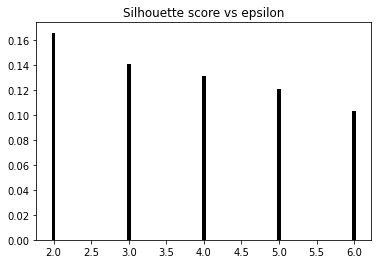

Best epsilon = 5


In [ ]:
plt.figure()
plt.bar(ms_list, silhouette_scores, width=0.05, color='k', align='center')
plt.title('Silhouette score vs epsilon')
plt.show()
# Best params
print("Best epsilon =", ms_best)

# 전처리

In [382]:
import pandas as pd
# TODO : 한줄씩 크롤링해오는 것으로 변경되었으므로 불러오는 로직 수정해야 함

def json_to_df(folder, paths) :
    df_all = pd.DataFrame(columns=['title', 'article', 'concat'])
    for path in paths :
        with open(f'./{folder}/{path}', 'r') as f:
            df = pd.read_json(f)
        df.drop(['id', 'category', 'publish_date', 'extractive', 'abstractive'], axis=1, inplace=True)
        
        df['concat'] = ''
        for i in range(len(df['article'])):
            result = []
            for j in range(len(df['article'][i])):
                result.append(df['article'][i][j]['sentence'].strip())
            df['article'][i] =''.join(result)
            df['concat'][i] = df['title'][i]+' '+df['article'][i]
        df_all = pd.concat([df_all, df], ignore_index=True)
    return df_all   


In [383]:
import os
news_folder = os.path.join('', '20211211')
news_file_list = os.listdir(f'./{news_folder}')
df = json_to_df(news_folder, news_file_list)
df['concat'][1234]

'유희열, 코로나19 확진..백신접종 완료, 돌파감염 사례 가수 겸 방송인 유희열이 코로나19 확진 판정을 받았다고 소속사 안테나가 11일 밝혔다.유희열은 전날 오전 스케줄을 위해 진행한 자가진단검사에서 의심 증상이 나타나 일정을 취소하고 코로나19 검사를 받았다. 그 결과 이날 밤 양성 판정을 받았다.유희열은 지난 8월 말 코로나19 예방을 위한 2차 백신 접종까지 마쳤다.안테나측은 "유희열은 방역당국 지침에 따라 필요한 조치를 하고 있다"며 "당사 접촉 스태프 역시 코로나19 검사를 진행 중"이라고 밝혔다.김광태기자 ktkim@dt.co.kr'

In [381]:
import string
import re


def preprocess(sent, exclude): # 유니코드 지우기(안지워짐ㅜㅜ)
    """ 클러스터링을 위한 전처리 """
    total =''
    email = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
    sent = re.sub(email, '', sent) # 이메일 지우기
    for chr in sent:
        if chr not in exclude or chr == '.': total += chr
    return total

In [384]:
exclude = string.punctuation + '‘’·“”…◆\'△☆/★■\\▲▶\"▷◎▶▲◀☎◇↑☞『』☏‥◈▷【】�◈-'

for i in range(len(df['concat'])):
    sent = preprocess(df['concat'][i], exclude)
    # tmp = ' '.join(han.nouns(sent))
    df['concat'][i] = sent


In [385]:
def filter_sentence_articles(df):
    drop_index_list = [] # 지워버릴 index를 담는 리스트
    for i in range(len(df['article'])):
        if len(df['article'][i]) < 300 or df['article'][i].count('다.') < 3:
            drop_index_list.append(i)         
    df = df.drop(drop_index_list) # 해당 index를 지우기
    return df

In [386]:
df = filter_sentence_articles(df)
df

,title,article,concat
2,영광옥당여성노인회 조기주회장 '2021 서울평화문화대상' 실버리더상 수상,[영광=아시아경제 호남취재본부 이전성 기자] 전남 영광군 옥당여성노인회 조기주(여·...,영광옥당여성노인회 조기주회장 2021 서울평화문화대상 실버리더상 수상 영광아시아경제...
3,"현실판 화살촉? ""메뉴 표절"" 유튜버 허위 저격에 별점테러 당한 업체",구독자 154만명 규모의 유튜브 채널을 운영하는 승우아빠(본명 목진화)가 다른 업체...,현실판 화살촉 메뉴 표절 유튜버 허위 저격에 별점테러 당한 업체 구독자 154만명 ...
4,최대호 안양시장 1기신도시 특별법 제정촉구,11일 안양시에 따르면 최대호 시장은 지난 10일 서울 여의도 국회의원회관에서 열린...,최대호 안양시장 1기신도시 특별법 제정촉구 11일 안양시에 따르면 최대호 시장은 지...
5,충남 천안 산란계 농장서 고병원성 AI 의심 사례 발생..종사자·차량 이동 중지,충남 천안의 한 산란계 농장에서 고병원성 조류인플루엔자 의심 사례가 나왔습니다.조류...,충남 천안 산란계 농장서 고병원성 AI 의심 사례 발생..종사자차량 이동 중지 충남...
6,원주 25명 코로나 추가 확진..선제검사⋅가족접촉 다수,"11일 시 보건당국에 따르면 2485번은 해외입국자로 분류됐다.2486, 2487,...",원주 25명 코로나 추가 확진..선제검사⋅가족접촉 다수 11일 시 보건당국에 따르면...
...,...,...,...
3149,"'600억 기부' 약속 지킨 이주용 회장 ""돈을 쓰는 건 예술""",이 회장은 KCC정보통신 창립 50주년이었던 2017년 “총 600억원을 기부하겠다...,600억 기부 약속 지킨 이주용 회장 돈을 쓰는 건 예술 이 회장은 KCC정보통신 ...
3150,"포스코, 결국 '물적분할' 택했다..소액주주 '설득' 가능할까?",[더팩트｜윤정원 기자] POSCO(포스코)가 물적분할 방식을 통한 지주사 체제 전환...,포스코 결국 물적분할 택했다..소액주주 설득 가능할까 더팩트｜윤정원 기자 POSCO...
3151,'제2의 창업' 선언한 정창선 회장..대우건설 '쇄신 인사' 단행할까,[더팩트｜이민주 기자] 중흥그룹이 대우건설 인수 작업을 마무리 지었다.정창선 중흥그...,제2의 창업 선언한 정창선 회장..대우건설 쇄신 인사 단행할까 더팩트｜이민주 기자 ...
3152,[주간사모펀드] M&A 대어 '미니스톱' 온다..유력 PEF 운용사는?,"스톤브릿지‧아주IB, 중고 명품 플랫폼 '구구스' 인수[더팩트｜윤정원 기자] 한국미...",주간사모펀드 MA 대어 미니스톱 온다..유력 PEF 운용사는 스톤브릿지‧아주IB 중...


In [387]:
from konlpy.tag import Hannanum
han = Hannanum()

In [395]:
df['concat']

2       영광옥당여성노인회 조기주회장 2021 서울평화문화대상 실버리더상 수상 영광아시아경제...
3       현실판 화살촉 메뉴 표절 유튜버 허위 저격에 별점테러 당한 업체 구독자 154만명 ...
4       최대호 안양시장 1기신도시 특별법 제정촉구 11일 안양시에 따르면 최대호 시장은 지...
5       충남 천안 산란계 농장서 고병원성 AI 의심 사례 발생..종사자차량 이동 중지 충남...
6       원주 25명 코로나 추가 확진..선제검사⋅가족접촉 다수 11일 시 보건당국에 따르면...
                              ...                        
3149    600억 기부 약속 지킨 이주용 회장 돈을 쓰는 건 예술 이 회장은 KCC정보통신 ...
3150    포스코 결국 물적분할 택했다..소액주주 설득 가능할까 더팩트｜윤정원 기자 POSCO...
3151    제2의 창업 선언한 정창선 회장..대우건설 쇄신 인사 단행할까 더팩트｜이민주 기자 ...
3152    주간사모펀드 MA 대어 미니스톱 온다..유력 PEF 운용사는 스톤브릿지‧아주IB 중...
3153    불장이던 광명집값 하락전환..수도권 상승세 둔화 이데일리 강신우 기자 수도권 아파트...
Name: concat, Length: 2348, dtype: object

In [390]:
for i in range(len(df['concat'])):
        tmp = ' '.join(han.nouns(df['concat'][i]))
        df['concat_nouns'][i] = tmp

KeyError: 0

In [172]:
from collections import defaultdict
import re 
del_list = defaultdict(int)
total = ''
for i in df['article']:
    korean = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')
    x = re.compile('[\'\".,@!$=+%^&*(\[\])]')
    parseText= re.sub(korean, '', i)
    parseText= re.sub('[a-zA-Z0-9가-힇ㄱ-ㅎㅏ-ㅣぁ-ゔァ-ヴー々〆〤一-龥]', '', parseText)
    parseText= re.sub(x, '', parseText)
    parseText=''.join(parseText)
    total += parseText
for i in total:
    del_list[i] += 1

In [65]:
pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # 이메일 제거
test = "rkskek 가나다 kwoun1008@gmail.com"
print(re.sub(pattern, '',test))

rkskek 가나다 


In [ ]:
import unidecode

text = df['article'][57]
re.sub(pattern,'',text)


In [88]:
u = '\xa0 \u200b ◈ � \u2008 \u2002 \ufeff \ue0c8'
u= 'apple  bc' 

re.sub(r'[a]+','',u)

'pple  bc'

In [43]:
del_list

defaultdict(int,
            {' ': 11698227,
             '\xa0': 27048,
             '‘': 55435,
             '’': 56055,
             '→': 3743,
             '·': 87437,
             '~': 18230,
             '“': 83745,
             '”': 83494,
             '-': 30359,
             '/': 30258,
             ':': 26533,
             '…': 5653,
             '㎞': 1049,
             '㎡': 4117,
             '△': 16140,
             '<': 3872,
             '>': 9416,
             '◇': 5528,
             '▲': 16291,
             '☞': 4882,
             'Δ': 5420,
             '◆': 4447,
             '■': 2489,
             '‧': 1775,
             '_': 1338,
             '?': 12379,
             '\u200b': 135,
             'ㆍ': 1007,
             '『': 53,
             '』': 55,
             '∼': 2890,
             '【': 924,
             '】': 924,
             '▶': 6753,
             '☎': 479,
             '#': 2744,
             '●': 221,
             '◀': 1510,
             '▷': 7121,
       